In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras import models
from keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam

batch_size = 10
epochs = 10
img_width, img_height = 224, 224

In [7]:
train_dir = 'furniture_data/train'
val_dir = 'furniture_data/test'

train_bed_dir = os.path.join(train_dir, 'bed') 
train_chair_dir = os.path.join(train_dir, 'chair')  
train_sofa_dir = os.path.join(train_dir, 'sofa') 
val_bed_dir = os.path.join(val_dir, 'bed')  
val_chair_dir = os.path.join(val_dir, 'chair')  
val_sofa_dir = os.path.join(val_dir, 'sofa')

In [9]:
num_bed_train = len(os.listdir(train_bed_dir))
num_chair_train = len(os.listdir(train_chair_dir))
num_sofa_train = len(os.listdir(train_sofa_dir))

num_bed_val = len(os.listdir(val_bed_dir))
num_chair_val = len(os.listdir(val_chair_dir))
num_sofa_val = len(os.listdir(val_sofa_dir))

num_train_img = num_bed_train + num_chair_train + num_sofa_train
num_val_img = num_bed_val + num_chair_val + num_sofa_val
print(num_train_images, num_val_images)

4480 1170


In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

Found 4480 images belonging to 3 classes.


In [25]:
val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size)

Found 1170 images belonging to 3 classes.


In [14]:
# plot images in the form of a grid where images are placed in each column
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

58892288/58889256 [==============================] - 4s 0us/step


In [19]:
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    # initiate fine-tuning from this layer onwards
    fine_tune_at = 100
    
    # freeze all layers before the fine-tuned initiation
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    for fc in fc_layers:
        # new fc layer, random init
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
        
    # new softmax layer
    predictions = Dense(num_classes, activation='softmax')(x)
    
    final_model = Model(inputs=base_model.input, outputs=predictions)
    
    return final_model

classes = ['bed', 'chair', 'sofa']
fc_layers = [1024, 1024]
dropout = 0.2

model = build_final_model(base_model,
                          dropout=dropout,
                          fc_layers=fc_layers,
                          num_classes=len(classes)
                          )

In [22]:
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
history = model.fit(train_generator, epochs=epochs, steps_per_epoch=num_train_img // batchsize,
                    validation_data=val_generator, validation_steps=num_val_img // batchsize)

Epoch 1/10
448/448 [==============================] - 1209s 3s/step - loss: 0.9899 - accuracy: 0.6558 - val_loss: 0.5028 - val_accuracy: 0.8034
Epoch 2/10
448/448 [==============================] - 1103s 2s/step - loss: 0.6111 - accuracy: 0.7895 - val_loss: 0.4106 - val_accuracy: 0.8513
Epoch 3/10
448/448 [==============================] - 1116s 2s/step - loss: 0.5063 - accuracy: 0.8212 - val_loss: 0.3458 - val_accuracy: 0.8769
Epoch 4/10
448/448 [==============================] - 1249s 3s/step - loss: 0.4418 - accuracy: 0.8417 - val_loss: 0.3569 - val_accuracy: 0.8761
Epoch 5/10
448/448 [==============================] - 1190s 3s/step - loss: 0.4146 - accuracy: 0.8556 - val_loss: 0.3258 - val_accuracy: 0.8786
Epoch 6/10
448/448 [==============================] - 1194s 3s/step - loss: 0.3737 - accuracy: 0.8743 - val_loss: 0.2983 - val_accuracy: 0.8880
Epoch 7/10
448/448 [==============================] - 1072s 2s/step - loss: 0.3340 - accuracy: 0.8770 - val_loss: 0.2930 - val_accuracy:

In [27]:
print(len(model.layers))

26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


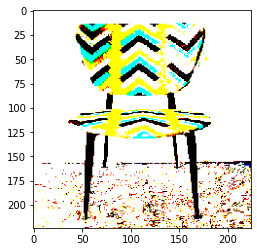

In [31]:
img_path = 'furniture_data/test/chair/00000800.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

featuremap = model.predict(img_tensor)
plt.imshow(featuremap)
plt.imshow(img_tensor[0])
print(img_tensor.shape)

In [32]:
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]]
activation_model_fig = Model(inputs=model.input, outputs=layer_outputs)
activations_fig = activation_model_fig.predict(img_tensor)

(1, 224, 224, 3)


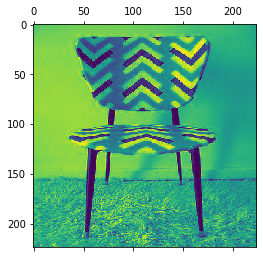

In [33]:
first_layer_activation = activations_fig[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

<ipython-input-34-fd09538110d5>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-34-fd09538110d5>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-34-fd09538110d5>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returne

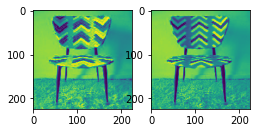

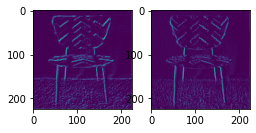

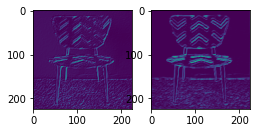

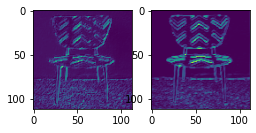

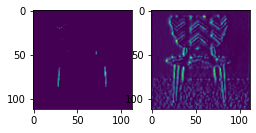

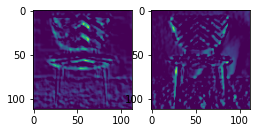

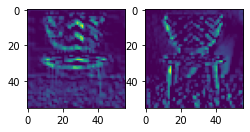

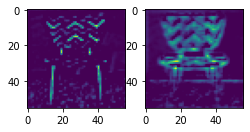

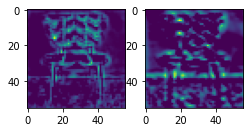

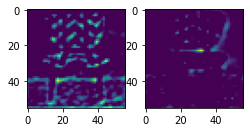

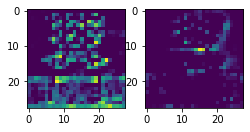

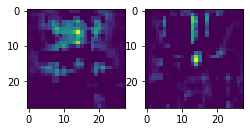

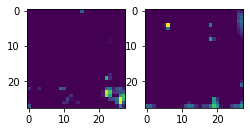

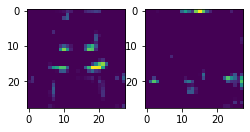

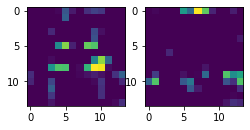

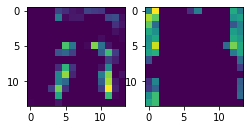

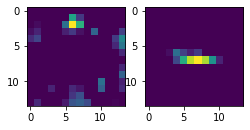

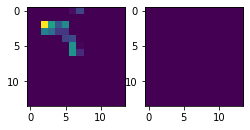

In [34]:
for i in range(0, len(model.layers)-8):
    current_layer_activation = activations_fig[i]
    ns = current_layer_activation.shape[-1]
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    plt.subplot(131)
    plt.imshow(current_layer_activation[0, :, :, 0], cmap='viridis')
    
    ax3 = fig.add_subplot(132)
    plt.subplot(132)
    plt.imshow(current_layer_activation[0, :, :, int(ns/2)], cmap='viridis')
    
    ax5 = fig.add_subplot(132)
    plt.subplot(132)
    plt.imshow(current_layer_activation[0, :, :, ns-1], cmap='viridis')